ANLY 590 \
Final Project \
December 16, 2020 \
Random Forrest: Chris Fiaschetti, Ryan Callahan, Ruchikaa Kanar & Masha Gubenko

Github repo: https://github.com/mgubenko/590Project

In [1]:
#drive.mount('/content/gdrive/')

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import keras
from keras import layers


#from google.colab import drive
import numpy as np
import pandas as pd
import scipy.io
import os
import PIL
from PIL import Image
from numpy import asarray
#import cache_magic
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from os import makedirs
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as Net
import random
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


## Data Preprocessing

This portion of the code preprocesses the data. It combines the images data with its labels and produces train and test sets.

In [2]:
# Define list that will hold all filenames in sequence
file_string_list = []
# Define list that will hold arrays of pictures' pixels in sequence
data_list = []

# Save string that is beginning of every image's filepath
dirpath='Images/'
# Save list of all folders of dog breeds
folders = os.listdir(dirpath)
# For each folder (i.e. breed)...
for folder in folders:
  # Print the folder (i.e. breed) name for tracking purposes
  print(folder)
  # Save current folder's path as separate string
  folderpath = dirpath + folder + '/'
  # Save all filenames within current folder to list
  file_list = os.listdir(folderpath)
  # For each file in this folder...
  for filename in file_list:
    # Save string that is that file's filepath
    filepath = folderpath + filename
    # Open the image at that filepath
    image = Image.open(filepath)
    # Resize image to 200x200 pixels to enable input into neural network
    image_resized = image.resize((200,200))
    # Convert this resized image to array
    data = asarray(image_resized)
    # Append this 200x200x3 array to list of all images' arrays
    data_list.append(data)

    # Save this image's folder and filename as string, which matches the folder-filename combination in the [file list-breed label] array below for later merger (i.e. we will be merging
    # image arrays and breed labels using the filenames)
    file_string = folder + '/' + filename
    # Add this image's filename to list of all filenames, which will be in same sequence as list of all image data
    file_string_list.append(file_string)
    


n02097658-silky_terrier
n02092002-Scottish_deerhound
n02099849-Chesapeake_Bay_retriever
n02091244-Ibizan_hound
n02095314-wire-haired_fox_terrier
n02091831-Saluki
n02102318-cocker_spaniel
n02104365-schipperke
n02090622-borzoi
n02113023-Pembroke
n02105505-komondor
n02093256-Staffordshire_bullterrier
n02113799-standard_poodle
n02109961-Eskimo_dog
n02089973-English_foxhound
n02099601-golden_retriever
n02095889-Sealyham_terrier
n02085782-Japanese_spaniel
n02097047-miniature_schnauzer
n02110063-malamute
n02105162-malinois
n02086079-Pekinese
n02097130-giant_schnauzer
n02113978-Mexican_hairless
n02107142-Doberman
n02097209-standard_schnauzer
n02115913-dhole
n02106662-German_shepherd
n02106382-Bouvier_des_Flandres
n02110185-Siberian_husky
n02094258-Norwich_terrier
n02093991-Irish_terrier
n02094114-Norfolk_terrier
n02109525-Saint_Bernard
n02093754-Border_terrier
n02105251-briard
n02108551-Tibetan_mastiff
n02108422-bull_mastiff
n02085936-Maltese_dog
n02093859-Kerry_blue_terrier
n02104029-kuvasz
n

In [3]:
# Save strings of filepaths for files that contain images' filenames and associated labels
file1 = "file_list.mat"
file2 = "test_list.mat"
file3 = "train_list.mat"
## Read in files that contain images' filenames and associated labels
mat1 = scipy.io.loadmat(file1)
mat2 = scipy.io.loadmat(file2)
mat3 = scipy.io.loadmat(file3)

In [4]:
# Save list of filenames of images in test set
test_filenames_list = mat2['file_list']
# Define list that will hold filenames in test set after they've been stripped of their triple-array packing
test_filenames = []
# For each filename in the test set...
for filename in test_filenames_list:
  # Strip off array wrapping and add to list of cleaned filenames
  test_filenames.append(filename[0][0])
# Convert filenames list to DataFrame column for concatenation
test_filenames = pd.DataFrame(np.array(test_filenames).reshape((len(test_filenames),1)))
# Convert labels list to DataFrame column for concatenation
test_labels = pd.DataFrame(mat2['labels'])
# Concatenate filenames and labels
test_file_label = pd.concat((test_labels,test_filenames),axis=1)
# Add column names to concatenated dataframe
test_file_label.columns=['label','filename']

# Save list of filenames of images in training set
train_filenames_list = mat3['file_list']
# Define list that will hold filenames in training set after they've been stripped of their triple-array packing
train_filenames = []
# For each filename in the training set...
for filename in train_filenames_list:
  # Strip off array wrapping and add to list of cleaned filenames
  train_filenames.append(filename[0][0])
# Convert filenames list to DataFrame column for concatenation
train_filenames = pd.DataFrame(np.array(train_filenames).reshape((len(train_filenames),1)))
# Convert labels list to DataFrame column for concatenation
train_labels = pd.DataFrame(mat3['labels'])
# Concatenate filenames and labels
train_file_label = pd.concat((train_labels,train_filenames),axis=1)
# Add column names to concatenated dataframe
train_file_label.columns=['label','filename']

In [5]:
# Save all image arrays as dataframe
a = pd.DataFrame(data_list)
# Rename column of image arrays
a = a.rename(columns={0:'data'})
# Add filenames, which were acquired in sequence during original for loop, as column in dataframe
a['filename'] = file_string_list
# Create dataframe of training image arrays
train_file = train_file_label.merge(a, on='filename', how='inner')
# Create dataframe of test image arrays
test_file = test_file_label.merge(a, on='filename', how='inner')

/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/pandas/core/internals/construction.py:230: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [6]:
# Save list of training set labels
y_train_numbers = train_file.label
# Define array that will hold training set labels in softmax form
y_train = np.zeros((y_train_numbers.shape[0],120))
# For each image...
for i in range(y_train_numbers.shape[0]):
    # Flip the appropriate column's entry (each column represents a different breed) to 1
    y_train[i,y_train_numbers[i]-1] = 1
# Save list of test set labels
y_test_numbers = test_file.label
# Define array that will hold test set labels in softmax form
y_test = np.zeros((y_test_numbers.shape[0],120))
# For each image...
for i in range(y_test_numbers.shape[0]):
    # Flip the appropriate column's entry (each column represents a different breed) to 1
    y_test[i,y_test_numbers[i]-1] = 1

In [7]:
# Save series of image arrays as list
X_train = list(train_file.data)
# Remove empty 4th dimension from 7904th image
X_train[7904] = X_train[7904][:,:,0:3]
# Convert training set to numpy array and normalize variables
X_train = np.array(X_train).astype('float32') / 255.

In [8]:
# Convert test set to numpy array and normalize variables
X_test = np.array(list(test_file.data)).astype('float32') / 255.

## Models

### CNN with 3x3 kernels

The first two models are representative of the approximately 20 "handmade" models that we tested. We experimented with different combinations of padding, stride length, network depth hidden layer size, activation functions, etc... Spoiler alert is that none of these models significantly outperformed random guessing.

This first model is very standard - 3x3 kernels throughout, strides of 1 in both axes throughout, ReLU activation functions, padding that preserves dimensions, and a neuron sequence of 32-32-64-64-128-128-32.

In [9]:
# Start with empty sequential model
model = Sequential()
# Add pair of 32-neuron hidden layers with ReLU activation function, 3x3 kernel, stride length of 1 in both dimensions, and padding that maintains 32x32 shape
model.add(tfkl.Conv2D(32, (3,3), strides=(1,1), activation='relu', padding='same', input_shape=(200, 200, 3)))
model.add(tfkl.Conv2D(32, (3,3), strides=(1,1), activation='relu', padding='same'))
# Max pooling of 2x2 sections to get dimensionality of each image down to 16x16
model.add(tfkl.MaxPooling2D((2, 2)))
# Add pair of 64-neuron hidden layers with ReLU activation function, 3x3 kernel, stride length of 1 in both dimensions, and padding that maintains 16x16 shape
model.add(tfkl.Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
model.add(tfkl.Conv2D(64, (3,3), strides=(1,1), activation='relu', padding='same'))
# Max pooling of 2x2 sections to get dimensionality of each image down to 8x8
model.add(tfkl.MaxPooling2D((2, 2)))
# Add pair of 128-neuron hidden layers with ReLU activation function, 3x3 kernel, stride length of 1 in both dimensions, and padding that maintains 8x8 shape
model.add(tfkl.Conv2D(128, (3,3), strides=(1,1), activation='relu', padding='same'))
model.add(tfkl.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
# Max pooling of 2x2 sections to get dimensionality of each image down to 4x4
model.add(tfkl.MaxPooling2D((2, 2)))
# Flatten 4x4x128 network into 
model.add(tfkl.Conv2D(32, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(120, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)       7

In [10]:
model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))

188/188 [==============================] - 677s 4s/step - loss: 4.7888 - accuracy: 0.0087 - val_loss: 4.7876 - val_accuracy: 0.0138


In [11]:
#Calculate the validation accuracy levels to see how the model performed
acc1 = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc1[0],acc1[1]))

269/269 [==============================] - 100s 370ms/step - loss: 4.7876 - accuracy: 0.0138
Test set
  Loss: 4.788
  Accuracy: 0.014


### CNN with 6x6 kernel

Second model only changes the kernel size to 6x6; otherwise, we keep strides of 1 in both axes throughout, ReLU activation functions, padding that preserves dimensions, and a neuron sequence of 32-32-64-64-128-128-32.

In [12]:
# Start with empty sequential model
model2 = Sequential()
# Add pair of 32-neuron hidden layers with ReLU activation function, 3x3 kernel, stride length of 1 in both dimensions, and padding that maintains 32x32 shape
model2.add(tfkl.Conv2D(32, (6,6), strides=(1,1), activation='relu', padding='same', input_shape=(200, 200, 3)))
model2.add(tfkl.Conv2D(32, (6,6), strides=(1,1), activation='relu', padding='same'))
# Max pooling of 2x2 sections to get dimensionality of each image down to 16x16
model2.add(tfkl.MaxPooling2D((2, 2)))
# Add pair of 64-neuron hidden layers with ReLU activation function, 3x3 kernel, stride length of 1 in both dimensions, and padding that maintains 16x16 shape
model2.add(tfkl.Conv2D(64, (6,6), strides=(1,1), activation='relu', padding='same'))
model2.add(tfkl.Conv2D(64, (6,6), strides=(1,1), activation='relu', padding='same'))
# Max pooling of 2x2 sections to get dimensionality of each image down to 8x8
model2.add(tfkl.MaxPooling2D((2, 2)))
# Add pair of 128-neuron hidden layers with ReLU activation function, 3x3 kernel, stride length of 1 in both dimensions, and padding that maintains 8x8 shape
model2.add(tfkl.Conv2D(128, (6,6), strides=(1,1), activation='relu', padding='same'))
model2.add(tfkl.Conv2D(128, (6,6), strides=(1,1), activation='relu', padding='same'))
# Max pooling of 2x2 sections to get dimensionality of each image down to 4x4
model2.add(tfkl.MaxPooling2D((2, 2)))
# Flatten 4x4x128 network into 
model2.add(tfkl.Conv2D(32, (6,6), strides=(1,1), activation='relu', padding='same'))
#model2.add(layers.Conv2D(16, (6,6), strides=(1,1), activation='relu', padding='same'))
model2.add(tfkl.Flatten())
model2.add(tfkl.Dense(120, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 200, 200, 32)      3488      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 32)      36896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      73792     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 64)      147520    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 128)      

In [13]:
model2.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))

188/188 [==============================] - 2120s 11s/step - loss: 4.7977 - accuracy: 0.0072 - val_loss: 4.7876 - val_accuracy: 0.0087


In [14]:
#Calculate the validation accuracy levels to see how the model performed
acc2 = model2.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc2[0],acc2[1]))

269/269 [==============================] - 282s 1s/step - loss: 4.7875 - accuracy: 0.0087
Test set
  Loss: 4.788
  Accuracy: 0.009


As we said, we tried a large number of different "handmade" models, with all of them having a validation set accuracy of approximately 0.9% (equivalent to random guessing).

### Transfer Learning Models

After all of those "handmade" models failed, we used transfer learning models for this image classification task.

#### VGG Model

In [15]:
# Import library that contains VGG weights

# Construct variable that uses VGG weights for 200x200x3 input image
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(200,200,3))
# Define transfer learning model
model3 = Sequential()
# Freeze VGG weights
conv_base.trainable=False
# Add VGG weights to model
model3.add(conv_base)
# Add final dense 120-element layer that will contain softmax probabilities
model3.add(tfkl.GlobalMaxPool2D())
model3.add(tfkl.Dense(120,activation='softmax'))
# Compile model
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
# Print model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Fit the model
model3.fit(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_test, y_test))

750/750 [==============================] - 1361s 2s/step - loss: 4.8512 - categorical_accuracy: 0.0330 - val_loss: 3.8737 - val_categorical_accuracy: 0.1284


In [17]:
#Calculate the validation accuracy levels to see how the model performed
acc3 = model3.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc3[0],acc3[1]))

269/269 [==============================] - 558s 2s/step - loss: 3.8737 - categorical_accuracy: 0.1284
Test set
  Loss: 3.874
  Accuracy: 0.128


#### Xception Model

In [18]:
# Import library that contains Xception weights

# Construct variable that uses Xception weights for 200x200x3 input image
conv_base = Xception(weights="imagenet",include_top=False,input_shape=(200,200,3))
# Define transfer learning model
model4 = Sequential()
# Freeze Xception weights
conv_base.trainable=False
# Add Xception weights to model
model4.add(conv_base)
# Add final dense 120-element layer that will contain softmax probabilities
model4.add(tfkl.GlobalMaxPool2D())
model4.add(tfkl.Dense(120,activation='softmax'))
# Compile model
model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
# Print model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               245880    
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
# Fit the model
model4.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

375/375 [==============================] - 703s 2s/step - loss: 2.3424 - categorical_accuracy: 0.5390 - val_loss: 1.2336 - val_categorical_accuracy: 0.7204


In [20]:
#Calculate the validation accuracy levels to see how the model performed
acc4 = model4.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc4[0],acc4[1]))

269/269 [==============================] - 297s 1s/step - loss: 1.2336 - categorical_accuracy: 0.7204
Test set
  Loss: 1.234
  Accuracy: 0.720


#### ResNet Model

In [21]:
# Construct variable that uses ResNet weights for 200x200x3 input image
conv_base = ResNet50V2(weights="imagenet",include_top=False,input_shape=(200,200,3))
# Define transfer learning model
model5 = Sequential()
# Freeze ResNet weights
conv_base.trainable=False
# Add ResNet weights to model
model5.add(conv_base)
# Add final dense 120-element layer that will contain softmax probabilities
model5.add(tfkl.GlobalMaxPool2D())
model5.add(tfkl.Dense(120,activation='softmax'))
# Compile model
model5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
# Print model summary
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
model5.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

375/375 [==============================] - 538s 1s/step - loss: 13.2497 - categorical_accuracy: 0.2688 - val_loss: 7.2558 - val_categorical_accuracy: 0.5052


In [23]:
#Calculate the validation accuracy levels to see how the model performed
acc5 = model5.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc5[0],acc5[1]))

269/269 [==============================] - 221s 822ms/step - loss: 7.2558 - categorical_accuracy: 0.5052
Test set
  Loss: 7.256
  Accuracy: 0.505


#### Efficient Net Model

In [24]:
# Construct variable that uses Efficient Net weights for 200x200x3 input image
efnet = Net(weights = "imagenet", include_top = False, input_shape = (200,200,3))
# Freeze Efficiet Net weights
efnet.trainable = False

In [25]:
# Define transfer learning model
mnet = Sequential()
# Add Efficient Net weights to model
mnet.add(efnet)
# Add final dense 120-element layer that will contain softmax probabilities
mnet.add(tfkl.GlobalMaxPooling2D(name = "gap"))
mnet.add(tfkl.Flatten())
mnet.add(tfkl.Dense(120, activation='softmax'))
# Compile model
mnet.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
mnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               153720    
Total params: 4,203,291
Trainable params: 153,720
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
#Fit the model
mnet.fit(X_train, y_train, epochs=1, steps_per_epoch= 2, batch_size=64, validation_data = (X_test,y_test))

2/2 [==============================] - 175s 170s/step - loss: 9.1571 - accuracy: 0.0156 - val_loss: 9.0473 - val_accuracy: 0.0066


In [27]:
#Calculate the validation accuracy levels to see how the model performed
acc_ts = mnet.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_ts[0],acc_ts[1]))

269/269 [==============================] - 147s 546ms/step - loss: 9.0473 - accuracy: 0.0066
Test set
  Loss: 9.047
  Accuracy: 0.007


Looking at the relative performance of each of these standalone models, we see that the Xception embeddings performed best (72% test set accuracy), followed by ResNet (50.5% test set accuracy), followed by VGG (12.8% accuracy), and finally Efficient Net (equivalent to random guessing). This is despite the fact that VGG took nearly twice as long as Xception, and more than twice as long as ResNet, to train this single epoch.

### Ensemble Models

As the meat of our project, we used ensemble models for image classification, to see if we could improve upon the performance of the standalone models.

#### Ensembles of Transfer Learning Models

We will now try to ensemble combinations of transfer learning models. First, we make an ensemble of Xception, ResNet, and VGG models, the three best-performing models.

In [28]:
# Save Xception model that was trained above
model4.save('models/model_4.h5')
# Save ResNet model that was trained above
model5.save('models/model_5.h5')

In [29]:
# Define empty list that will hold transfer sub-models
all_tran_models = list()
# Load Xception model
model4 = load_model('models/model_4.h5')
# Add Xception model to list
all_tran_models.append(model4)
# Load ResNet model
model5 = load_model('models/model_5.h5')
# Add ResNet model to list
all_tran_models.append(model5)

# Evaluate and print accuracy of Xception and ResNet models in isolation (for comparison against ensemble accuracy)
model4_acc = model4.evaluate(X_test,y_test)
model5_acc = model5.evaluate(X_test,y_test)
print('Xception accuracy:',model4_acc)
print('ResNet accuracy:',model5_acc)

269/269 [==============================] - 218s 809ms/step - loss: 7.2558 - categorical_accuracy: 0.5052
Xception accuracy: [1.2335715293884277, 0.7203962802886963]
ResNet accuracy: [7.255791664123535, 0.5052447319030762]


In [30]:
# Save VGG model to file
model3.save('models/model_3.h5')
# Load VGG model from disk
model3 = load_model('models/model_3.h5')
# Add VGG model to list of models
all_tran_models.append(model3)
# Evaluate and print performance of VGG model in isolation
model3_acc = model3.evaluate(X_test,y_test)
print('VGG accuracy:',model3_acc)

269/269 [==============================] - 528s 2s/step - loss: 3.8737 - categorical_accuracy: 0.1284
VGG accuracy: [3.8736929893493652, 0.12843823432922363]


In [31]:
## Define function that makes predictions based on fit ensemble model
def stacked_prediction(members, model, inputX):
    # Create stacked copies of dataset
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction on stacked, copied dataset using ensemble model
    yhat = model.predict(stackedX)
    return yhat

## Function creates multiple copies of X for evaluation
def stacked_dataset(members, inputX):
    # Define structure that will hold all predictions
    stackX = None
    # For each model contributing to ensemble...
    for model in members:
        # Make predictions using this model
        yhat = model.predict(inputX)
        # If stack is empty, start stack with predictions from this model
        if stackX is None:
            stackX = yhat
        # If stack is not empty, add predictions from this model to stack
        else:
            stackX = dstack((stackX, yhat))
    # Flatten predictions of all models into [observations, models x probabilities] shape
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    # Return flattened predictions
    return stackX

# Define function that fits ensemble model
def fit_stacked_model(members, inputX, inputy):
    # Create dataset of multiple copies of datset for use in ensemble model
    stackedX = stacked_dataset(members, inputX)
    # Fit ensemble model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

In [32]:
# Use 2 aforementioned functions to create dataset shape to fit ensemble model, and then fit ensemble model
model_ensemble = fit_stacked_model(all_tran_models, X_test, np.array(y_test_numbers))


# Make predictions using fit ensemble model
yhat = stacked_prediction(all_tran_models, model_ensemble, X_test)
# Print accuracy of ensemble model
acc = accuracy_score(np.array(y_test_numbers), yhat)
print('Stacked Test Accuracy: %.3f' % acc)

/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Stacked Test Accuracy: 0.771


We achieved a test accuracy of 77.1% with an ensemble model that included VGG-, ResNet-, and Xception-informed standalone models, which is better than any of those models' performance in isolation. Now we will try to add an Efficient Net model to this ensemble to see if it further improves its performance.

In [33]:
# Save Efficient Net transfer learning model
mnet.save('models/emnet.h5')
# Load Efficient Net transfer learning model
model6 = load_model('models/emnet.h5')
# Add Efficient Net model to list of all models
all_tran_models.append(model6)
# Evaluate Efficient Net's standalone accuracy
model6_acc = model6.evaluate(X_test,y_test)
print('Efficient Net Accuracy:',model6_acc)

269/269 [==============================] - 154s 566ms/step - loss: 9.0473 - accuracy: 0.0066
Efficient Net Accuracy: [9.047321319580078, 0.006643356755375862]


In [34]:
# Fit ensemble model that now includes fourth transfer model, the Efficient Net
model_ensemble2 = fit_stacked_model(all_tran_models, X_test, np.array(y_test_numbers))
# Make predictions using new (four-piece) ensemble model
yhat2 = stacked_prediction(all_tran_models, model_ensemble2, X_test)
# Print accuracy of new ensemble model
acc2 = accuracy_score(np.array(y_test_numbers), yhat2)
print('Stacked Test Accuracy: %.3f' % acc2)

/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Stacked Test Accuracy: 0.771


Alas, the addition of the Efficient Net model did not further improve the ensemble's performance, though that is not especially surprising because the Efficient Net model's standalone test accuracy was barely better than random guessing.

#### Ensemble of Simple Models

We also constructed an ensemble of a set of simple "handmade" models to see if we can outperform our standalone "handmade" models from above (which could not outperform random guessing).

In [35]:
## Define function that defines, compiles, fits, and returns a simple model
def fit_model(trainX, trainy):
    # define model
    model_little = Sequential()
    model_little.add(tfkl.Conv2D(32, (5,5), strides=(1,1), activation='relu', padding='same', input_shape=(200, 200, 3)))
    model_little.add(tfkl.MaxPooling2D((4, 4)))
    model_little.add(tfkl.Conv2D(16, (5,5), strides=(1,1), activation='relu', padding='same'))
    model_little.add(tfkl.MaxPooling2D((2, 2)))
    model_little.add(tfkl.Conv2D(8, (3,3), strides=(1,1), activation='relu', padding='same'))
    model_little.add(tfkl.MaxPooling2D((2, 2)))
    model_little.add(tfkl.Conv2D(4, (3,3), strides=(1,1), activation='relu', padding='same'))
    model_little.add(tfkl.MaxPooling2D((2, 2)))
    model_little.add(tfkl.Flatten())
    model_little.add(tfkl.Dense(120, activation='softmax'))
    model_little.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_little.fit(X_train, y_train, epochs=5)
    return model_little

## Define function that loads a (simple) model and adds that model to the list of all models
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model___' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


## Define function that loads a (simple) model and adds that model to the list of all models
def load_all_sub_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_sub_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

First, we will create an ensemble model out of 5 individual models that were each trained on the entire training set.

In [36]:
#makedirs('models')

## fit and save models
n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(X_train, y_train)
    # save model
    filename = 'models/model___' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

all_simple_models = load_all_models(n_members)
print('Loaded %d models' % len(all_simple_models))

for model in all_simple_models:
    #y_test_enc = to_categorical(y_test_numbers)
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('Model Accuracy: %.3f' % acc)

# Use 2 aforementioned functions to create dataset shape to fit ensemble model, and then fit ensemble model
simple_model_ensemble = fit_stacked_model(all_simple_models, X_test, np.array(y_test_numbers))

# Make predictions using fit ensemble model
yhat_simple = stacked_prediction(all_simple_models, simple_model_ensemble, X_test)
# Print accuracy of ensemble model
acc_ensemble = accuracy_score(np.array(y_test_numbers), yhat_simple)
print('Stacked Test Accuracy: %.3f' % acc_ensemble)

Epoch 1/5
375/375 [==============================] - 142s 379ms/step - loss: 4.7884 - accuracy: 0.0077
Epoch 2/5
375/375 [==============================] - 144s 383ms/step - loss: 4.7851 - accuracy: 0.0086
Epoch 3/5
375/375 [==============================] - 143s 381ms/step - loss: 4.6693 - accuracy: 0.0250
Epoch 4/5
375/375 [==============================] - 143s 382ms/step - loss: 4.5108 - accuracy: 0.0375
Epoch 5/5
375/375 [==============================] - 144s 383ms/step - loss: 4.4113 - accuracy: 0.0493
>Saved models/model___1.h5
Epoch 1/5
375/375 [==============================] - 143s 381ms/step - loss: 4.7889 - accuracy: 0.0080
Epoch 2/5
375/375 [==============================] - 143s 381ms/step - loss: 4.7531 - accuracy: 0.0127
Epoch 3/5
375/375 [==============================] - 142s 379ms/step - loss: 4.5107 - accuracy: 0.0356
Epoch 4/5
375/375 [==============================] - 142s 379ms/step - loss: 4.3906 - accuracy: 0.0491
Epoch 5/5
375/375 [===========================

/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Stacked Test Accuracy: 0.074


In this case, the test set accuracy of each individual model was between 3% and 4% (these were trained for 5 times as long as the sample "handmade" models shown at the beginning of the code, allowing for slight improvement from their ~0.9% random guessing accuracy), while the ensemble model has a test accuracy of 7.4%, approximately two times as high as the performance of the individual models.

Next, we will create an ensemble model using 5 individual models that were each trained on a random fifth of the training dataset.

In [37]:
## fit and save models
n_members = 5
for i in range(n_members):
    # Define first and last indices of section of training set that will be used to train this simple network
    start = int((i/n_members)*len(X_train))
    stop = int(((i+1)/n_members)*len(X_train))
    model = fit_model(X_train[start:stop,:,:,:], y_train[start:stop,:])
    # save model
    filename = 'models/model_sub_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)


all_simple_sub_models = load_all_sub_models(n_members)
print('Loaded %d models' % len(all_simple_sub_models))


for model in all_simple_sub_models:
    #y_test_enc = to_categorical(y_test_numbers)
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('Model Accuracy: %.3f' % acc)

# Use 2 aforementioned functions to create dataset shape to fit ensemble model, and then fit ensemble model
simple_sub_model_ensemble = fit_stacked_model(all_simple_sub_models, X_test, np.array(y_test_numbers))


# Make predictions using fit ensemble model
yhat_simple_sub = stacked_prediction(all_simple_sub_models, simple_sub_model_ensemble, X_test)
# Print accuracy of ensemble model
acc_ensemble_sub = accuracy_score(np.array(y_test_numbers), yhat_simple_sub)
print('Stacked Test Accuracy: %.3f' % acc_ensemble_sub)

Epoch 1/5
375/375 [==============================] - 142s 377ms/step - loss: 4.7899 - accuracy: 0.0096
Epoch 2/5
375/375 [==============================] - 141s 376ms/step - loss: 4.7875 - accuracy: 0.0072
Epoch 3/5
375/375 [==============================] - 141s 377ms/step - loss: 4.6903 - accuracy: 0.0208
Epoch 4/5
375/375 [==============================] - 142s 378ms/step - loss: 4.5077 - accuracy: 0.0405
Epoch 5/5
375/375 [==============================] - 141s 376ms/step - loss: 4.3861 - accuracy: 0.0518
>Saved models/model_sub_1.h5
Epoch 1/5
375/375 [==============================] - 143s 381ms/step - loss: 4.7893 - accuracy: 0.0086
Epoch 2/5
375/375 [==============================] - 142s 379ms/step - loss: 4.7799 - accuracy: 0.0127
Epoch 3/5
375/375 [==============================] - 142s 379ms/step - loss: 4.7626 - accuracy: 0.0125
Epoch 4/5
375/375 [==============================] - 143s 381ms/step - loss: 4.6041 - accuracy: 0.0261
Epoch 5/5
375/375 [=========================

/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Stacked Test Accuracy: 0.054


Although the training times and individual models' performances were very similar to those exhibited in the ensemble model above (where each sub-model was trained on the full dataset), the ensemble's test set accuracy was nearly two percentage points lower than that of the ensemble composed of sub-models trained on the full dataset. Nevertheless, we still see that the ensembling of the models improves on their individual performances by 1%-2%.

Both of these handmade ensembles' performance metrics pale in comparison to the performance of the transfer learning ensembles.

### Plotting Results

In [38]:
model3 = load_model('models/model_3.h5')
model4 = load_model('models/model_4.h5')
model5 = load_model('models/model_5.h5')
model6 = load_model('models/emnet.h5')

In [39]:
def plotmodel(model, X_train, y_train, X_test, y_test):
    temp = []
    for i in [3000,6000,8000,10000,12000]:
        indices = random.sample(list(range(len(X_train))),i)
        a = X_train[indices,:,:,:]
        l = y_train[indices,:]
        model.fit(a,l, epochs=5, steps_per_epoch= 20, batch_size=64)
        temp.append(model.evaluate(X_test,y_test)[0])
    return temp

In [40]:
#Plot test accuracies for different train set size
size = [3000,6000,8000,10000,12000]
res1 = plotmodel(model3, X_train, y_train, X_test, y_test)
res2 = plotmodel(model4, X_train, y_train, X_test, y_test)
res3 = plotmodel(model5, X_train, y_train, X_test, y_test)
res4 = plotmodel(model6, X_train, y_train, X_test, y_test)

Epoch 1/5
20/20 [==============================] - 81s 4s/step - loss: 3.6123 - categorical_accuracy: 0.1953
Epoch 2/5
20/20 [==============================] - 82s 4s/step - loss: 3.5610 - categorical_accuracy: 0.2266
Epoch 3/5
20/20 [==============================] - 81s 4s/step - loss: 3.4960 - categorical_accuracy: 0.2358
Epoch 4/5
20/20 [==============================] - 81s 4s/step - loss: 3.4101 - categorical_accuracy: 0.2461
Epoch 5/5
269/269 [==============================] - 547s 2s/step - loss: 3.7084 - categorical_accuracy: 0.1691
Epoch 1/5
20/20 [==============================] - 80s 4s/step - loss: 3.4171 - categorical_accuracy: 0.2453
Epoch 2/5
20/20 [==============================] - 82s 4s/step - loss: 3.4467 - categorical_accuracy: 0.2477
Epoch 3/5
20/20 [==============================] - 81s 4s/step - loss: 3.4613 - categorical_accuracy: 0.2438
Epoch 4/5
20/20 [==============================] - 80s 4s/step - loss: 3.4311 - categorical_accuracy: 0.2430
Epoch 5/5
269/26

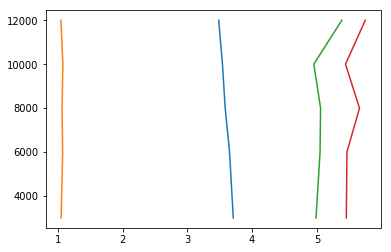

In [41]:
plt.plot(res1, size)
plt.plot(res2, size)
plt.plot(res3, size)
plt.plot(res4, size)
plt.xlabel('Loss - Categorical Cross-Entropy')
plt.ylabel('Training Set Size')
plt.title('Loss vs. Training Set Size')

X axis is categorical cross-entropy loss, Y axis is training set size. Red is Efficient Net, Green is VGG, Blue is ResNet, and Yellow is Xception (our project writeup contains a version of this plot with the axes labeled and an accompanying legend; the kernel continued to die and we therefore had to leave this as is). We see minimal improvement as the training set size increases, which matches our comparison of the "handmade" ensembles' individual sub-model performances.

In [42]:
def plotmodelacc(model, X_train, y_train, X_test, y_test):
    temp = []
    for i in [3000,6000,8000,10000,12000]:
        indices = random.sample(list(range(len(X_train))),i)
        a = X_train[indices,:,:,:]
        l = y_train[indices,:]
        model.fit(a,l, epochs=5, steps_per_epoch= 20, batch_size=64)
        temp.append(model.evaluate(X_test,y_test)[1])
    return temp

In [43]:
res1acc = plotmodelacc(model3, X_train, y_train, X_test, y_test)
res2acc = plotmodelacc(model4, X_train, y_train, X_test, y_test)
res3acc = plotmodelacc(model5, X_train, y_train, X_test, y_test)
res4acc = plotmodelacc(mnet, X_train, y_train, X_test, y_test)

Epoch 1/5
20/20 [==============================] - 75s 4s/step - loss: 3.0670 - categorical_accuracy: 0.3180
Epoch 2/5
20/20 [==============================] - 87s 4s/step - loss: 3.0699 - categorical_accuracy: 0.3102
Epoch 3/5
20/20 [==============================] - 82s 4s/step - loss: 3.0265 - categorical_accuracy: 0.3208
Epoch 4/5
20/20 [==============================] - 83s 4s/step - loss: 2.9854 - categorical_accuracy: 0.3320
Epoch 5/5
269/269 [==============================] - 549s 2s/step - loss: 3.4627 - categorical_accuracy: 0.2124
Epoch 1/5
20/20 [==============================] - 81s 4s/step - loss: 3.0056 - categorical_accuracy: 0.3281
Epoch 2/5
20/20 [==============================] - 83s 4s/step - loss: 3.0117 - categorical_accuracy: 0.3359
Epoch 3/5
20/20 [==============================] - 81s 4s/step - loss: 3.0214 - categorical_accuracy: 0.3180
Epoch 4/5
20/20 [==============================] - 81s 4s/step - loss: 3.0177 - categorical_accuracy: 0.3266
Epoch 5/5
269/26

In [44]:
res5acc = []
res6acc = []

for i in [3000,6000,8000,10000,12000]:
    
    plotted_models3 = []
    plotted_models4 = []
    indices = random.sample(list(range(len(X_train))),i)
    a = X_train[indices,:,:,:]
    l = y_train[indices,:]
    
    conv_base = ResNet50V2(weights="imagenet",include_top=False,input_shape=(200,200,3))
    modela = Sequential()
    conv_base.trainable=False
    modela.add(conv_base)
    modela.add(tfkl.GlobalMaxPool2D())
    modela.add(tfkl.Dense(120,activation='softmax'))
    modela.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    modela.fit(a,l, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    plotted_models3.append(modela)
    plotted_models4.append(modela)
    
    
    conv_base = Xception(weights="imagenet",include_top=False,input_shape=(200,200,3))
    modelb = Sequential()
    conv_base.trainable=False
    modelb.add(conv_base)
    modelb.add(tfkl.GlobalMaxPool2D())
    modelb.add(tfkl.Dense(120,activation='softmax'))
    modelb.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    modelb.fit(a,l, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    plotted_models3.append(modelb)
    plotted_models4.append(modelb)
    

    conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(200,200,3))
    modelc = Sequential()
    conv_base.trainable=False
    modelc.add(conv_base)
    modelc.add(tfkl.GlobalMaxPool2D())
    modelc.add(tfkl.Dense(120,activation='softmax'))
    modelc.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    modelc.fit(a,l, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    plotted_models3.append(modelc)
    plotted_models4.append(modelc)
    
    
    efnet = Net(weights = "imagenet", include_top = False, input_shape = (200,200,3))
    efnet.trainable = False
    # Define transfer learning model
    modeld = Sequential()
    # Add Efficient Net weights to model
    modeld.add(efnet)
    # Add final dense 120-element layer that will contain softmax probabilities
    modeld.add(tfkl.GlobalMaxPooling2D(name = "gap"))
    modeld.add(tfkl.Flatten())
    modeld.add(tfkl.Dense(120, activation='softmax'))
    # Compile model
    modeld.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    modeld.fit(a,l, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    plotted_models4.append(modeld)
    
    
    
    plotted_model_ensemble3 = fit_stacked_model(plotted_models3, X_test, np.array(y_test_numbers))
    plotted_model_ensemble4 = fit_stacked_model(plotted_models4, X_test, np.array(y_test_numbers))
    
    yhat3 = stacked_prediction(plotted_models3, plotted_model_ensemble3, X_test)
    yhat4 = stacked_prediction(plotted_models4, plotted_model_ensemble4, X_test)
    
    acc3 = accuracy_score(np.array(y_test_numbers), yhat3)
    acc4 = accuracy_score(np.array(y_test_numbers), yhat4)

    res5acc.append(acc3)
    res6acc.append(acc4)

94/94 [==============================] - 205s 2s/step - loss: 8.1123 - accuracy: 0.0093 - val_loss: 6.0406 - val_accuracy: 0.0082


/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


188/188 [==============================] - 272s 1s/step - loss: 7.4590 - accuracy: 0.0066 - val_loss: 6.0966 - val_accuracy: 0.0084


/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


250/250 [==============================] - 306s 1s/step - loss: 6.7735 - accuracy: 0.0077 - val_loss: 5.8803 - val_accuracy: 0.0096


/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


313/313 [==============================] - 334s 1s/step - loss: 6.9216 - accuracy: 0.0086 - val_loss: 5.9486 - val_accuracy: 0.0063


/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


375/375 [==============================] - 381s 1s/step - loss: 6.6528 - accuracy: 0.0085 - val_loss: 6.2193 - val_accuracy: 0.0061


/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/christopherfiaschetti/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


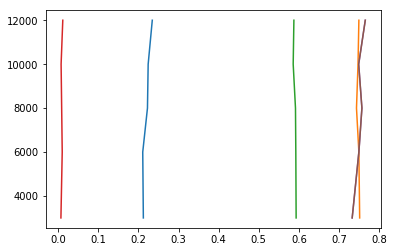

In [45]:
plt.plot(res1acc, size)
plt.plot(res2acc, size)
plt.plot(res3acc, size)
plt.plot(res4acc, size)
plt.plot(res5acc, size)
plt.plot(res6acc, size)

In this plot, X axis is test set accuracy, Y axis is training set size (and again, our project writeup contains a version of this plot with the axes labeled and an accompanying legend; the kernel continued to die and we therefore had to leave this as is). In this plot, the maroon line is both ensemble models, because as we saw, the addition of Efficient Net to the ensemble adds no value (orange is Xception along, Green is ResNet alone, Blue is VGG alone, and Red is Efficient Net alone). And again, we see minimal improvement as the training set size increases.